In [262]:
import pandas as pd
from gensim import corpora, models, similarities
from nltk.tokenize import TweetTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
train_df = pd.read_csv('std_data/MCTest/mc500/mc500.train.csv',index_col=0)

In [264]:
#train_df = train_df[(train_df.question_type=='one')].reset_index(drop=True)
#train_df.head()

In [277]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

def rmv_stwd(sentence):
    return [w for w in sentence if not w in stop_words] 
    

def compare(options,query,argmax=True):
    options = [word_tokenize(t.lower()) for t in  options] #lower + tokenise
    #options = [rmv_stwd(opt) for opt in options] 
    
    dictionary = corpora.Dictionary(options)
    feature_cnt = len(dictionary.token2id)
    corpus = [dictionary.doc2bow(opt) for opt in options]
    tfidf = models.TfidfModel(corpus) 

    kw_vector = dictionary.doc2bow(word_tokenize(query.lower()))
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features = feature_cnt)
    sim = index[tfidf[kw_vector]]
    if argmax:
        return np.argmax(sim)
    return sim



In [285]:
compare(train_df['article'][1].split('.'),train_df['question'][1])

4

In [286]:
train_df['question'][1]

'Why did Alyssa go to Miami?'

In [287]:
train_df['article'][1].split('.')[3]

" She's now in Miami"

In [284]:
options = [train_df['A'][0],train_df['B'][0],train_df['C'][0],train_df['D'][0]]
compare(options,train_df['article'][0].split('.')[3])

1

In [270]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(train_df['answer'])[0]

1

In [271]:
n = 4 #related sentences
y_pred = []
for i in range(len(train_df)):
    try:
        sentences = train_df['article'][i].split('.')
        # find 3 most related sentence
        arr = compare(sentences,train_df['question'][i],False)
        idx = (-arr).argsort()[:n]

        #most_relevant_s = sentences[idx]
        most_relevant_s = '.'.join([sentences[i] for i in idx])

        options = [train_df['A'][i],train_df['B'][i],train_df['C'][i],train_df['D'][i]]
        y_pred.append(compare(options,most_relevant_s))
    except Exception as e :
        print(e)
        y_pred.append('e')

In [272]:
y_true = train_df['answer']
y_pred = le.inverse_transform(y_pred)

In [273]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=le.classes_))

Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.63      0.48       288
           B       0.50      0.49      0.50       283
           C       0.58      0.44      0.50       303
           D       0.56      0.40      0.46       326

    accuracy                           0.48      1200
   macro avg       0.51      0.49      0.49      1200
weighted avg       0.51      0.48      0.48      1200



[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C'), Text(0, 3.5, 'D')]

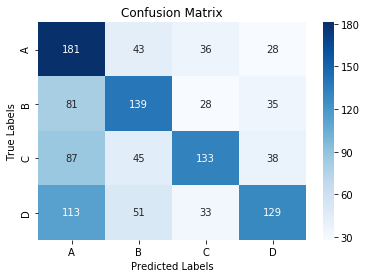

In [274]:
cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)